<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Comparing--Deep-Learning-APIs-for-Image-Multi-Label-Classification" data-toc-modified-id="Comparing--Deep-Learning-APIs-for-Image-Multi-Label-Classification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Comparing  Deep Learning APIs for Image Multi-Label Classification</a></span><ul class="toc-item"><li><span><a href="#Inception-V3" data-toc-modified-id="Inception-V3-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Inception V3</a></span></li><li><span><a href="#OpenAI-Clip" data-toc-modified-id="OpenAI-Clip-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>OpenAI Clip</a></span></li></ul></li></ul></div>

# Computer Vision

In [1]:
# Libraries 
import numpy as np
import tensorflow as tf
import os
import torch
import clip
import cv2
import json

from IPython.display import Image as Image_display
from IPython.display import display
from PIL import Image
from numba import cuda

##  Comparing  Deep Learning APIs for Image Multi-Label Classification

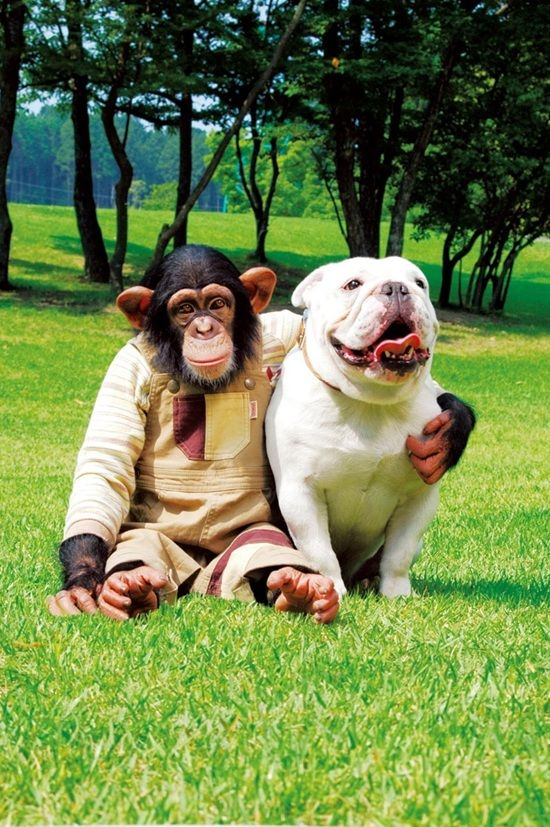

In [2]:
# Pick an image
#image_path = np.random.choice([os.path.join("images",a) for a in os.listdir("images")])
image_path = os.path.join("images","003.jpg")
display(Image_display(image_path))

### Inception V3

In [3]:
# Inception V3 model
inception_model = tf.keras.applications.InceptionV3(weights="imagenet", classifier_activation=None)

In [4]:
def predict_classes_inception(image_path, model, top=10):
    
    """
    Print predicted clases for a given image using inceptionV3
    
    Parameters
    ----------
    image_path : str
        The file location
    
    """
    
    # Load and process the input image
    image = tf.keras.preprocessing.image.load_img(image_path)
    image_arr = tf.keras.preprocessing.image.img_to_array(image)
    reshape_image = tf.image.resize(image_arr, size=(299,299), method='bilinear')
    input_inception = tf.keras.applications.inception_v3.preprocess_input(np.array([reshape_image]))
    
    # Make model predictions
    predictions = model.predict(input_inception)
    
    # Print predictions
    print("Top predictions: \n")
    for idx, pred in enumerate(tf.keras.applications.inception_v3.decode_predictions(predictions, top=top)[0]):
        print("{:02d}. {} - Score: {:.2f}".format(idx + 1,
                                          pred[1].replace("_"," ").title(), 
                                          pred[2]))

In [5]:
predict_classes_inception(image_path, inception_model, top=15)

Top predictions: 

01. American Staffordshire Terrier - Score: 7.63
02. French Bulldog - Score: 7.19
03. Staffordshire Bullterrier - Score: 7.04
04. Bull Mastiff - Score: 6.88
05. Pug - Score: 6.13
06. Boston Bull - Score: 4.83
07. Clumber - Score: 4.44
08. Boxer - Score: 4.18
09. Saint Bernard - Score: 4.06
10. Basset - Score: 3.90
11. Labrador Retriever - Score: 3.81
12. Tibetan Mastiff - Score: 3.46
13. Tibetan Terrier - Score: 3.40
14. Chow - Score: 3.34
15. Lhasa - Score: 3.28


### OpenAI Clip

In [6]:
# pip install git+https://github.com/openai/CLIP.git

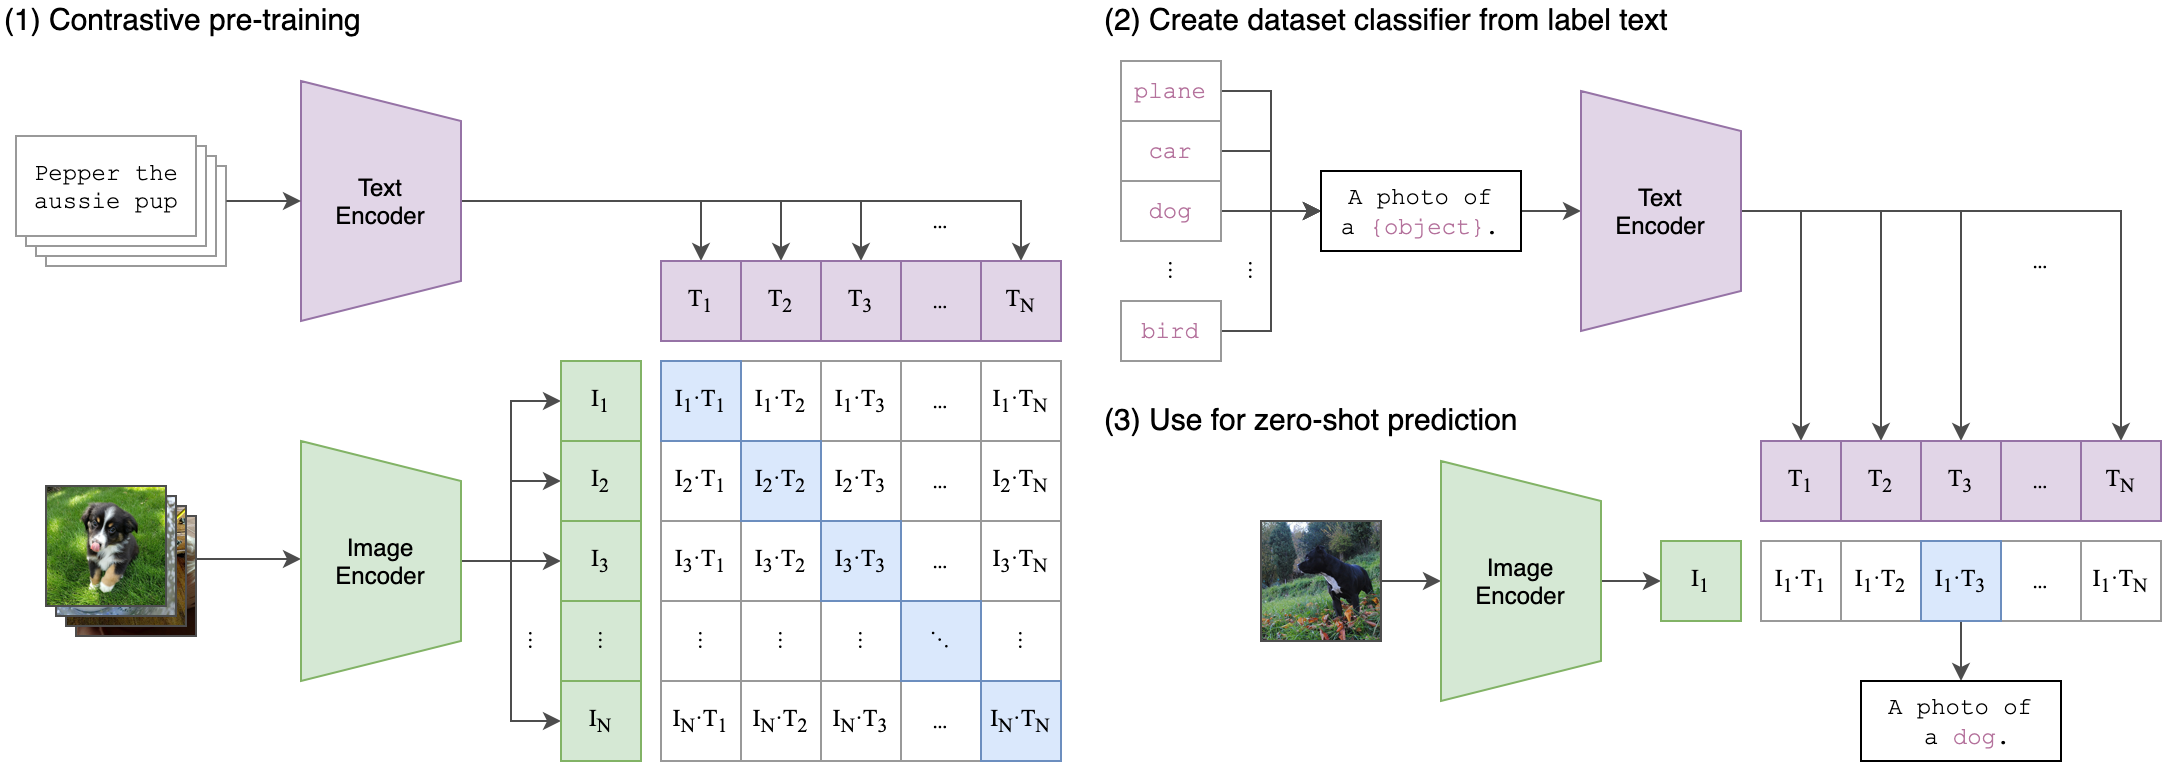

In [7]:
# OpenAI Diagram
display(Image_display(os.path.join("images","CLIP.png")))

In [8]:
# Load the model
try:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    clip_model, preprocess = clip.load('ViT-B/32', device)
except:
    cuda.get_current_device().reset()
    print("Current Device reset")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    clip_model, preprocess = clip.load('ViT-B/32', device)

Current Device reset


In [9]:
def predict_classes_clip(image_path, model, labels, top=10):
    
    """
    Print predicted clases for a given image using OpenAI Clip
    
    Parameters
    ----------
    image_path : str
        The file location
    
    labels: list[str]
        list containing the possible labels
        
    """
    # Transform image to PIL
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(img)
    im_pil
    
    # Prepare the inputs
    image_input = preprocess(im_pil).unsqueeze(0).to(device)
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in custom_list]).to(device)

    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Pick the top most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T)#.softmax(dim=-1)
    values, indices = similarity[0].topk(min(top,similarity[0].shape[0]))

    # Print predictions
    print("Top predictions: \n")
    for idx, (value, index) in enumerate(zip(values, indices)):
        #print(f"{custom_list[index].title():>25s}: {value.item():.2f}")
        print("{:02d}. {} - Score: {:.2f}".format(idx + 1,
                                          custom_list[index].title(), 
                                          value.item()))

In [10]:
# Load imagenet 1000 labels
with open('imagenet_1000_labels.json', 'r') as fp:
    imagenet_1000_labels = json.load(fp)

custom_list = list(imagenet_1000_labels.values())
custom_list = [a.split(",")[0] for a in custom_list]

In [11]:
predict_classes_clip(image_path, clip_model, labels=custom_list, top=15)

Top predictions: 

01. Chimpanzee - Score: 27.75
02. Japanese Spaniel - Score: 26.75
03. Staffordshire Bullterrier - Score: 26.75
04. Macaque - Score: 26.44
05. Hippopotamus - Score: 26.05
06. French Bulldog - Score: 25.95
07. Lhasa - Score: 25.84
08. Baboon - Score: 25.72
09. Gorilla - Score: 25.69
10. Saint Bernard - Score: 25.58
11. Shih-Tzu - Score: 25.55
12. Great Dane - Score: 25.36
13. Blenheim Spaniel - Score: 25.30
14. English Springer - Score: 25.20
15. Pug - Score: 25.16


# Sources

https://arxiv.org/pdf/1903.09190.pdf